<p>이 튜토리얼에서는 일반적이지 않은 데이터셋으로부터 데이터를 읽어오고 전처리하고 증가하는 방법을 알아보겠다.</p>

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 경고 메시지 무시하기
import warnings
warnings.filterwarnings("ignore")

plt.ion()

ImportError: cannot import name 'PILLOW_VERSION'

<p>우리가 다룰 데이터셋은 아래 조건과 같은 랜드마크가 있는 얼굴 사진이다.</p>
![image](https://user-images.githubusercontent.com/12128784/74215379-3eea0500-4ce4-11ea-847a-36f8a603574a.png)


<p>각가의 얼굴에 68개의 서로 다른 중요 포인트들이 존재합니다.</p>
<p>데이터셋은 아래와 같은 특징을 가진 CSV파일이 포함되어 있다.</p>


::

    image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
    0805personali01.jpg,27,83,27,98, ... 84,134
    1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312
::

In [51]:
a = [[i + j*10 for i in range(1,11)] for j in range(0, 10)]
print(a)




print("[1,2] : ", a[1,3])

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [31, 32, 33, 34, 35, 36, 37, 38, 39, 40], [41, 42, 43, 44, 45, 46, 47, 48, 49, 50], [51, 52, 53, 54, 55, 56, 57, 58, 59, 60], [61, 62, 63, 64, 65, 66, 67, 68, 69, 70], [71, 72, 73, 74, 75, 76, 77, 78, 79, 80], [81, 82, 83, 84, 85, 86, 87, 88, 89, 90], [91, 92, 93, 94, 95, 96, 97, 98, 99, 100]]


TypeError: list indices must be integers or slices, not tuple

In [4]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')
# print(landmarks_frame.iloc[1, 1:].as_matrix().astype('float').reshape(-1, 2))
# print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
n = 65
img_name = landmarks_frame.iloc[n, 0]                      #CSV파일의 1행0열부터 끝까지 전체 범위를 행렬화 그 후 n행 0열의 위치의 값을 return
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()        # n번째 행의 data들을 모두 행렬 형식으로 저장해둠
landmarks = landmarks.astype('float').reshape(-1, 2)       # 현재는 1차원 벡터로 되어있지만 이걸 2개씩 끊어서 다시 만듦

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))



Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


이미지와 랜드마크를 보여주는 함수를 작성후 실제로 적용해 보자.

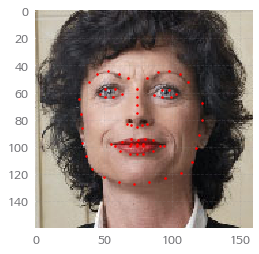

In [5]:
"""
landmarks[:,0]   :   처음부터 끝까지, 0열만
landmarks[:,1]   :   처음부터 끝까지, 1열만

scater
plt.scatter(x,y,s=None,c=None)
x,y : 좌표값
s : 마커의 크기
c : 마커의 색상

"""


def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker = '.', c='r')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)

plt.show()

In [6]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로
            root_dir (string): 모든 이미지가 존재하는 디렉토리 경로
            transform (callable, optional): 샘플에 적용될 Optional transform
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]              #idx 열의 1행부터 마지막까지
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample


0 (324, 215, 3) (68, 2)


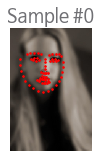

1 (500, 333, 3) (68, 2)


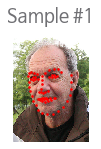

2 (250, 258, 3) (68, 2)


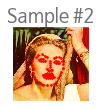

3 (434, 290, 3) (68, 2)


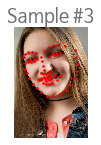

In [7]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]                #i번째의 image_path와 landmark정보를 받아옴

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

이제 사진들을 rescale하고 random crop하는 방법에 대하여 알아보자









In [14]:
class Rescale(object):
    """
    주어진 사이즈로 샘플크기를 조정합니다.

    Args:
        output_size(tuple or int) : 원하는 사이즈 값
            tuple인 경우 해당 tuple(output_size)이 결과물(output)의 크기가 되고,
            int라면 비율을 유지하면서, 길이가 작은 쪽이 output_size가 됩니다.
    """

    def __init__(self, output_size):
        # assert : 뒤의 조건이 True가 아니면 assert error를 발생시킴
        # isinstance(output_size, (int, tuple))
        assert isinstance(output_size, (int, tuple))   
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        #################################### 주어진 output의 비율에 맞게 조정해준다 #########################################
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        #####################################################################################################################
        img = transform.resize(image, (new_h, new_w))

        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """샘플데이터를 무작위로 자릅니다.

    Args:
        output_size (tuple or int): 줄이고자 하는 크기입니다.
                        int라면, 정사각형으로 나올 것 입니다.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        """
            __call__ : init과 비슷, 그러나 init은 인스턴스 초기화 할 때 불러와지고 call은 인스턴스가 호출될때 실행
            a = A()   ==> init실행
            a()       ==> call실행
        """
                
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """numpy array를 tensor(torch)로 변환 시켜줍니다."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

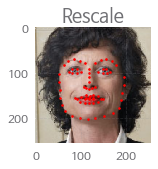

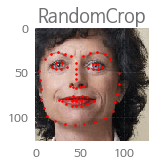

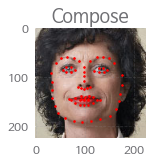

In [30]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

이제 위에서 배운것을 이용하여 transform해보고 이게 잘 되었는지 size를 출력하여 확인해보자.

In [46]:
#FaceLandmarksDataset은 image와 CSV파일 2개를 각각 따로 불러옴
#transformed_dataset[0]['image'] : 0번째 image가 저장되어있는 행렬
#transformed_dataset[0]['landmarks'] : 0번째 landmarks가 저장되어있는 행렬

transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


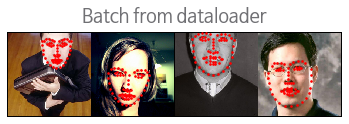

In [50]:
"""
Batch
우리는 전체 데이터를 나눠 묶은 batch라는 단위를 만들어 사용한다.
이 때 epoch는 모든 training data를 본것이고 interation은 batch_size단위로 몇번을 보았는지이다. 즉 data_size = batch_size*iterations이다.
이를 구현하기 위해서는 모든 데이터를 나누고 그에 맞춰 forward와 backward를 해주어야 한다. 하지만 pytorch에서 제공되는 DataLoader는 그럴 필요가 없다.
우리는 그냥 DataLoader로부터 batch_size만큼의 데이터를 받아오면 된다.

위에서 transform한 dataset을 batchsize는 4로 그리고 shuffle을 한 후 data를 load하자. 
이 때 num_workers는 멀티 쓰레딩을 지원하기 때문에 빠르게 데이터를 가져오고 싶다면 늘리자. 

"""

dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# 배치하는 과정을 보여주는 함수
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

        
        
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

우리가 지금까지 만든것이 torch에 모듈로 작성이 되있기도 한다. 쓰고 싶으면 다음과 같이 쓰면 된다.


현재는 dataset이 없으므로 오류가 뜨긴 하지만 데이터만 있으면 잘 실행 됨

In [54]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                              batch_size=4, shuffle=True,
                                              num_workers=4)

"""
training code에 대한 예시를 알고 싶다면,
:doc:`transfer_learning_tutorial` 문서를 참고해주세요

"""

FileNotFoundError: [Errno 2] No such file or directory: 'hymenoptera_data/train'